Пусть каждый объект имеет n признаков:
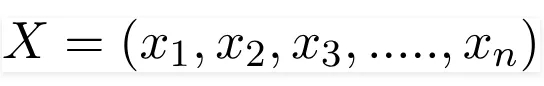

Воспользуемся теоремой Байеса и предположением о независимости признаков для предсказания и получим для класса y:
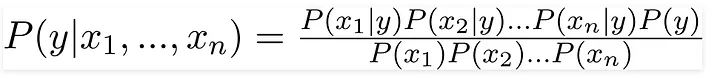

т. к. знаменатель не зависит от класса y, ответ нашей модели равен
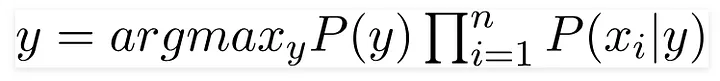

p. s. так как считать произведение не по кайфу, будем считать сумму логарифмов



Теперь как считать вероятности. Для нас это магия, но в scipy есть функция gaussian_kde, которая принимает список и как-то сглаживает распределение нашей фичи, превращая ее в непрерывную (наверное) функцию. Например как-то так:
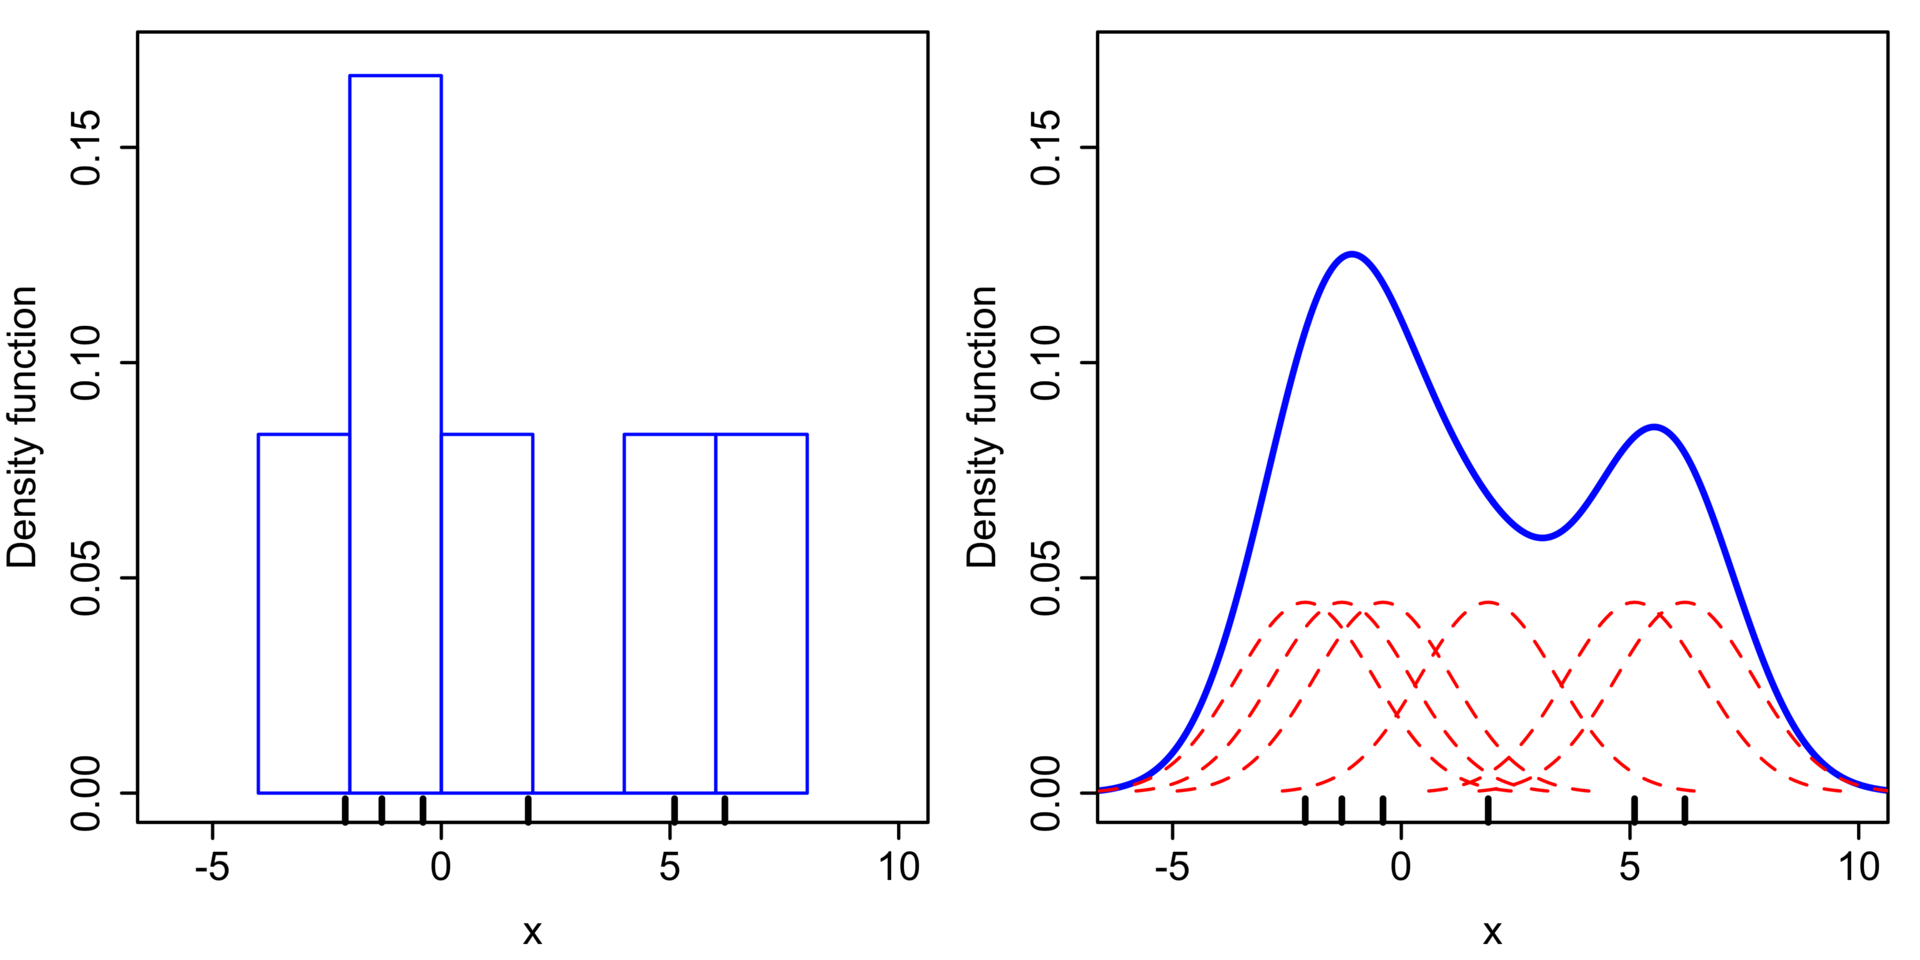

In [1]:
import numpy as np
import pandas as pd
from math import log, exp, sqrt, pi
import scipy
from math import log
from tqdm.auto import tqdm

In [2]:
class NaiveBayesClassifier:
    class Distribution:
        def __init__(self, feature_column, mode: str):
            self.mode = mode
            if mode == 'gaussian_kde':
                self.distribution = scipy.stats.gaussian_kde(feature_column)
            if mode == 'gaussian':
                self.mean = feature_column.mean()
                self.deviation = np.std(feature_column)
            if mode == 'cat_features':
                unique, counts = np.unique(feature_column, return_counts=True)
                self.distribution = dict(zip(unique, counts / feature_column.size))
                self.distribution = dict(zip(unique, counts / feature_column.size))

        def get_proba(self, value: float) -> float:
            if self.mode == 'gaussian':
                return self.get_prob_from_gauss(self, value, self.mean, self.deviation)
            if self.mode == 'gaussian_kde':
                return self.distribution.pdf(value)
            if value not in self.distribution.keys():
                return 0
            return self.distribution[value]

        @staticmethod
        def get_prob_from_gauss(self, value: float, mean: float, deviation: float) -> float:
            '''
            Вычисляет сложную формулу для вероятности из нормального распределения
            '''
            if deviation == 0:
                return 1
            return exp(-((value - mean) ** 2) / (2 * deviation ** 2)) / sqrt(
                2 * pi * deviation ** 2)

        def __str__(self):
            return str(self.distribution)

    def __init__(self, mode='gaussian_kde'):  # guassian_kde, guassian, cat_feautures
        self.distributions = None
        self.class_probability = None
        self.unique_labels = None
        self.mode = mode

    def fit(self, train_feature_matrix, train_labels):
        self.unique_labels = np.unique(train_labels)
        self.class_probability = {}  # здесь будем хранить долю каждого класса в выборке
        self.distributions = {}  # key: label, value: []
        # [i] - плотность распределения i-й фичи в X при условии, что класс = label, т.е. плотность распределения P(x_i | label))
        for label in self.unique_labels:
            current_label_feature_matrix = train_feature_matrix[np.array(train_labels == label)]
            self.class_probability[
                label] = current_label_feature_matrix.size / train_feature_matrix.size
            self.distributions[label] = []
            for feature_ind in range(train_feature_matrix.shape[1]):
                feature_column = current_label_feature_matrix.iloc[:, feature_ind]
                distribution = self.Distribution(feature_column,
                                                 self.mode)  # считаем плотность распределения P(x_feature_ind | label) с помощью gaussian_kde
                self.distributions[label].append(distribution)

    def predict(self, test_feature_matrix):
        y_pred = []  # наши предсказания
        for _, features in tqdm(test_feature_matrix.iterrows()):
            max_likelihood = -float('inf')
            predict = 0
            for label in self.unique_labels:  # перебираем возможные варианты ответа, выбираем - максимально правдоподобный
                likelihood = log(self.class_probability[label])  # здесь - сумма логарифмов вероятностей для label
                for feature_ind in range(test_feature_matrix.shape[1]):
                    if self.distributions[label][feature_ind].get_proba(
                            features[feature_ind]) == 0:
                        likelihood = -float('inf')
                    else:
                        likelihood += log(
                            self.distributions[label][feature_ind].get_proba(features[feature_ind]))
                if likelihood > max_likelihood:
                    max_likelihood = likelihood
                    predict = label
            y_pred.append(predict)
        return y_pred